# Defaults by Clients' Characteristics & Payment History

Apart from avoiding to onboard new risky clients, to effectively reduce defaults, it’s **also beneficial** to analyse the current client base by combining both entity characteristics (such as entity type and age) and transaction history (including payment behaviour, amounts, and frequency).

This allows us to build a profile of each client and better understand the patterns that indicate default-prone behaviour. By leveraging this information, we can predict not only whether a current client is likely to default in the future, but also whether a specific future transaction is at risk of default. This proactive prediction enables timely interventions, reducing the risk of defaults while preserving valuable client relationships.








In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
clients_payment_org = pd.read_csv(r'../data/ClientsPayments.csv', parse_dates=['transaction_datetime'])

## An overview of the problem on the whole dataset

In [3]:
total_money_defaults = clients_payment_org[clients_payment_org['payment_code']=='DEFAULT']['payment_amt'].sum().round(0)
proportion_of_defaults_amount = total_money_defaults / clients_payment_org['payment_amt'].sum()
total_num_defaults = clients_payment_org[clients_payment_org['payment_code']=='DEFAULT']['payment_amt'].count()
total_num_defaults_clients = clients_payment_org[clients_payment_org['payment_code']=='DEFAULT']['client_id'].nunique()
proportion_of_defaults = total_num_defaults / clients_payment_org['transaction_id'].nunique()
proportion_of_default_clients = total_num_defaults_clients / clients_payment_org['client_id'].nunique()

print(f'Total amount of money loss from defaults: ${total_money_defaults}')
print(f'Proportion of defaults amount: {proportion_of_defaults_amount:.2%}')
print(f'Total number of default cases: {total_num_defaults}')
print(f'Total number of clients with defaults: {total_num_defaults_clients}')
print(f'Proportion of defaults: {proportion_of_defaults:.2%}')
print(f'Proportion of clients with defaults: {proportion_of_default_clients:.2%}')



Total amount of money loss from defaults: $1496879.0
Proportion of defaults amount: 4.79%
Total number of default cases: 2219
Total number of clients with defaults: 365
Proportion of defaults: 8.68%
Proportion of clients with defaults: 28.49%


## Exploratory Analysis: Data patterns behind default behaviours

In this section I would focus on exploring transaction-related features as findings about the influence of entities' attributes on defaults have already been discussed in [this notebook](\client_attr_eda.ipynb).

In [4]:
clients_payment_df = clients_payment_org.drop(columns=['transaction_id', 'contract_id', 'client_id', 'entity_year_established'])
clients_payment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25559 entries, 0 to 25558
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   payment_amt                        25559 non-null  float64       
 1   payment_code                       25559 non-null  object        
 2   transaction_datetime               25559 non-null  datetime64[ns]
 3   total_amount_paid_before           25559 non-null  float64       
 4   avg_amount_per_transaction_before  25559 non-null  float64       
 5   num_payments_before                25559 non-null  int64         
 6   num_contracts_before               25559 non-null  int64         
 7   num_defaults_before                25559 non-null  int64         
 8   entity_type                        25559 non-null  object        
 9   entity_age                         25559 non-null  int64         
dtypes: datetime64[ns](1), float64(3), 

### By Clients' Payment History

In [5]:
# Group by payment_code (Default vs Non-Default) and get statistics for key variables
default_stats = clients_payment_df.groupby('payment_code').agg(
    total_amount_paid_before=('total_amount_paid_before', 'mean'),
    avg_amount_per_transaction_before=('avg_amount_per_transaction_before', 'mean'),
    num_payments_before=('num_payments_before', 'mean'),
    num_contracts_before=('num_contracts_before', 'mean'),
    total_num_defaults=('num_defaults_before', 'mean'),
    entity_age=('entity_age', 'mean')
).reset_index()

print(default_stats)


  payment_code  total_amount_paid_before  avg_amount_per_transaction_before  \
0      DEFAULT              16056.506142                        1042.776890   
1      PAYMENT              14988.196734                        2005.844751   

   num_payments_before  num_contracts_before  total_num_defaults  entity_age  
0            18.022533              1.200541            5.352411   14.836863  
1            12.274893              1.190060            1.266195   15.923608  


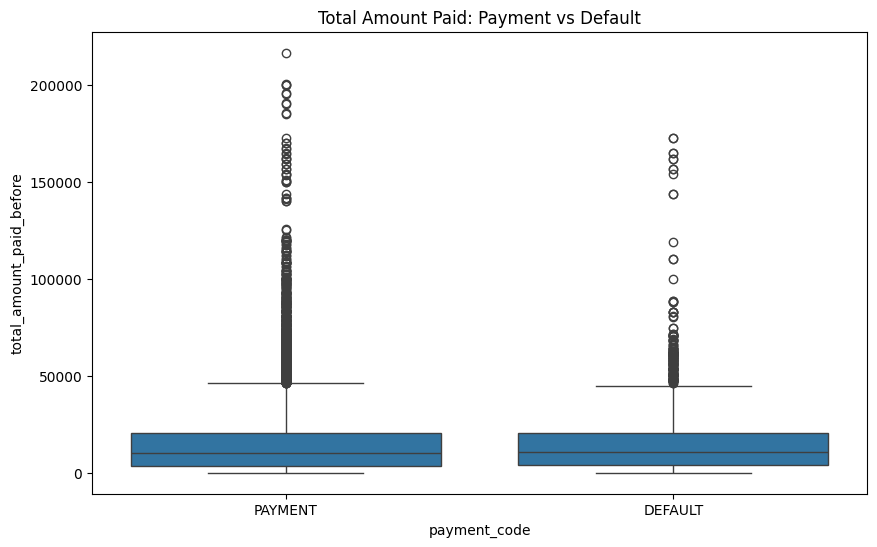

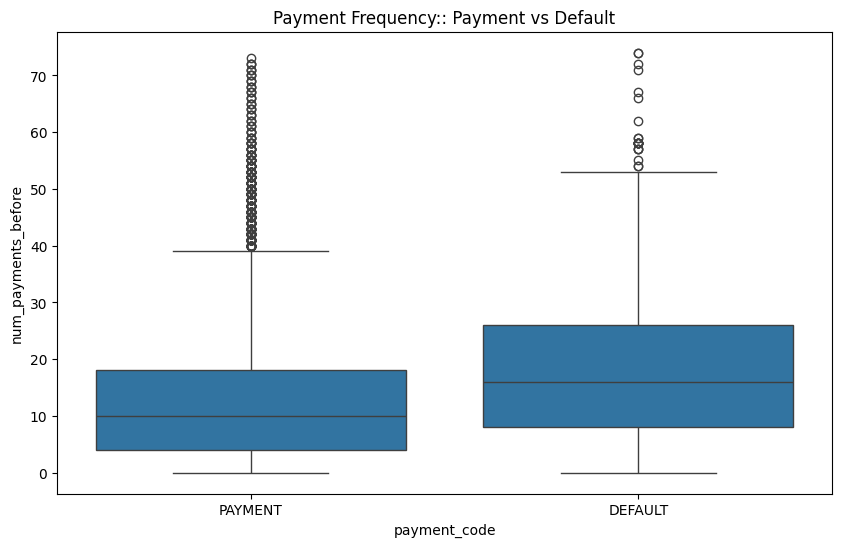

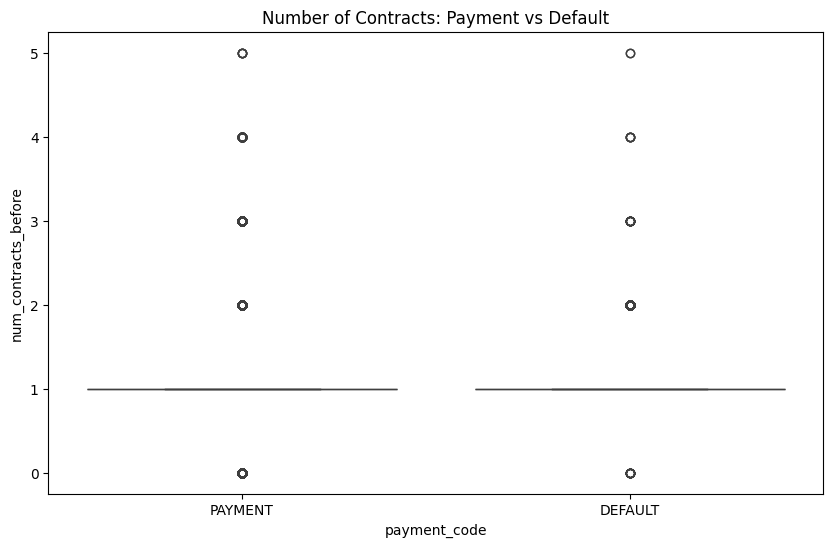

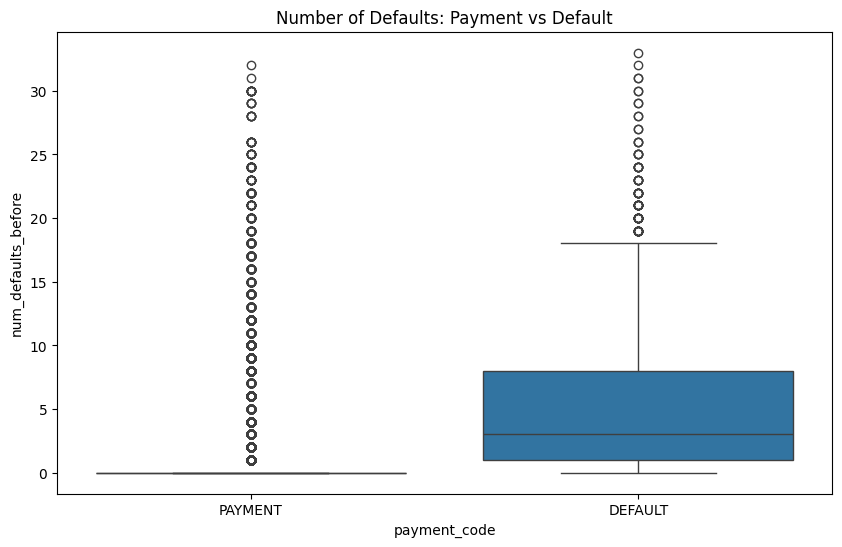

In [6]:
# Distribution of total amount paid before for default vs non-default
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_code', y='total_amount_paid_before', data=clients_payment_df)
plt.title('Total Amount Paid: Payment vs Default')
plt.show()

# Payment frequency vs default
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_code', y='num_payments_before', data=clients_payment_df)
plt.title('Payment Frequency:: Payment vs Default')
plt.show()

# number of contracts before default
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_code', y='num_contracts_before', data=clients_payment_df)
plt.title('Number of Contracts: Payment vs Default')
plt.show()

# number of defaults before default
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_code', y='num_defaults_before', data=clients_payment_df)
plt.title('Number of Defaults: Payment vs Default')
plt.show()



- Total Amount Paid: Clients who default tend to have a wider range of previous payment amounts. Some defaulting clients have made substantial payments in the past, suggesting that large payments alone are not sufficient to prevent defaults.

- Payment Frequency: Clients who default often make more frequent payments before the default, indicating that a history of frequent payments doesn’t necessarily guarantee that a client will avoid default. This suggests that payment behavior alone isn’t a reliable indicator of future payment reliability.

- Number of Contracts: There’s little difference between defaulting and non-defaulting clients in terms of number of contracts. This indicates that contract history might not be a strong predictor of future defaults, so focusing on other factors might be more effective.

- Number of Defaults: A strong indicator of future defaults is the number of past defaults. Clients who have previously defaulted multiple times are much more likely to default again, suggesting that tracking a client’s default history should be a priority for risk management.

### By Time Period

Text(0, 0.5, 'Count of Default Payments')

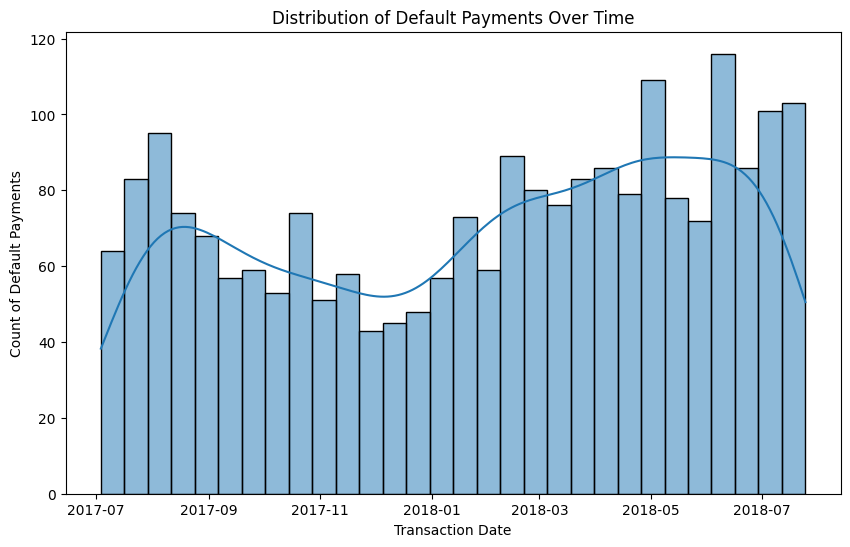

In [7]:
# histogram of date and count default payments
plt.figure(figsize=(10, 6))
sns.histplot(data=clients_payment_df[clients_payment_df['payment_code'] == 'DEFAULT'], x='transaction_datetime', bins=30, kde=True)
plt.title('Distribution of Default Payments Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Count of Default Payments')

The line trend suggests some seasonal behaviour, with peaks in mid-2017, mid-2018, and a slight dip around late 2017.

- Mid-year: In Australia, the financial year ends on June 30th, and businesses often prepare for tax returns and end-of-year financial settlements in June. This could cause a spike in defaults around that time as companies may face cash flow issues due to high end-of-year expenses or slower payments from customers during tax season.

- December/January: The Christmas and New Year period in Australia typically sees a slowdown in business activities, and many businesses close for extended periods. This could cause financial strain, leading to increased defaults in the months following, as businesses may struggle with income after the holiday period.

- March to May: The lead-up to Easter and the end of the first quarter of the fiscal year might also contribute to an increase in defaults due to seasonal revenue shifts.

Let's drill down by entity type to see when each client category is most likely to default.

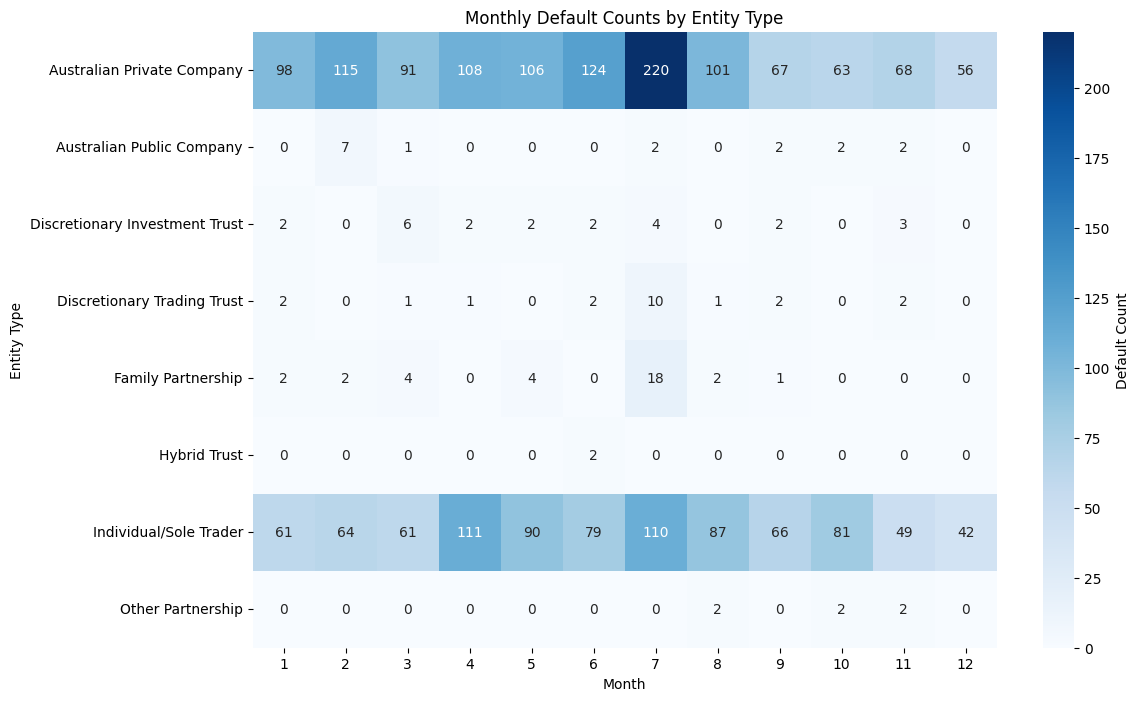

In [8]:
# default seems to have a seasonal effect so we would like to see default payments by month

clients_payment_df['month'] = clients_payment_df['transaction_datetime'].dt.month
monthly_defaults = clients_payment_df[clients_payment_df['payment_code'] == 'DEFAULT'].groupby(['entity_type', 'month']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_defaults, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Default Count'})
plt.title('Monthly Default Counts by Entity Type')
plt.xlabel('Month')
plt.ylabel('Entity Type')
plt.show()

- Australian Private Company: Defaults are high from the beginning of the year and peak in July, likely due to year-end financial stress. Other months show moderate defaults.

- Australian Public Company: Defaults are very low, with a slight increase in February.

- Discretionary Investment Trust: Default peaks in March and July, indicating potential seasonal influences.

- Discretionary Trading Trust: Defaults spike in July.

- Family Partnership: July sees the highest defaults, with a noticeable dip after.

- Hybrid Trust: Very low defaults, with a small peak in June.

- Individual/Sole Trader: High defaults in April, May, and July, especially around fiscal year-end.

- Other Partnership: Very low default counts, few cases in August, October, November.


Actions:
- Client Profiling: 
    - Based on the patterns, create risk profiles for each client based on the months they tend to default and other related factors like payment frequency, business type, and age.
    - Create an early warning system that flags customers who have historically defaulted during specific times of the year. Based on historical trends, we can anticipate defaults and take steps to prevent them.

- Proactive Customer Support: 
    - For clients with high default frequency during certain months, provide additional support in those months (e.g., early payment reminders, customized payment options, adjust payment term).
    - For example, if defaults peak during certain months, consider offering clients adjusted payment terms or lower monthly payments during these high-risk periods to help them avoid default.

### Multivariate Effect

#### Pearson Correlation Analysis

In [9]:
# one hot encoding of categorical variables
clients_payment_df = pd.get_dummies(clients_payment_df, columns=['entity_type'])

clients_payment_df['month'] = clients_payment_df['transaction_datetime'].dt.month.astype(int)
clients_payment_df['day_of_week'] = clients_payment_df['transaction_datetime'].dt.dayofweek.astype(int)
clients_payment_df['week_of_year'] = clients_payment_df['transaction_datetime'].dt.isocalendar().week.astype(int)

clients_payment_df['default'] = clients_payment_df['payment_code'].apply(lambda x: 1 if x == 'DEFAULT' else 0)

clients_payment_df.drop(columns=['payment_code', 'transaction_datetime'], inplace=True)



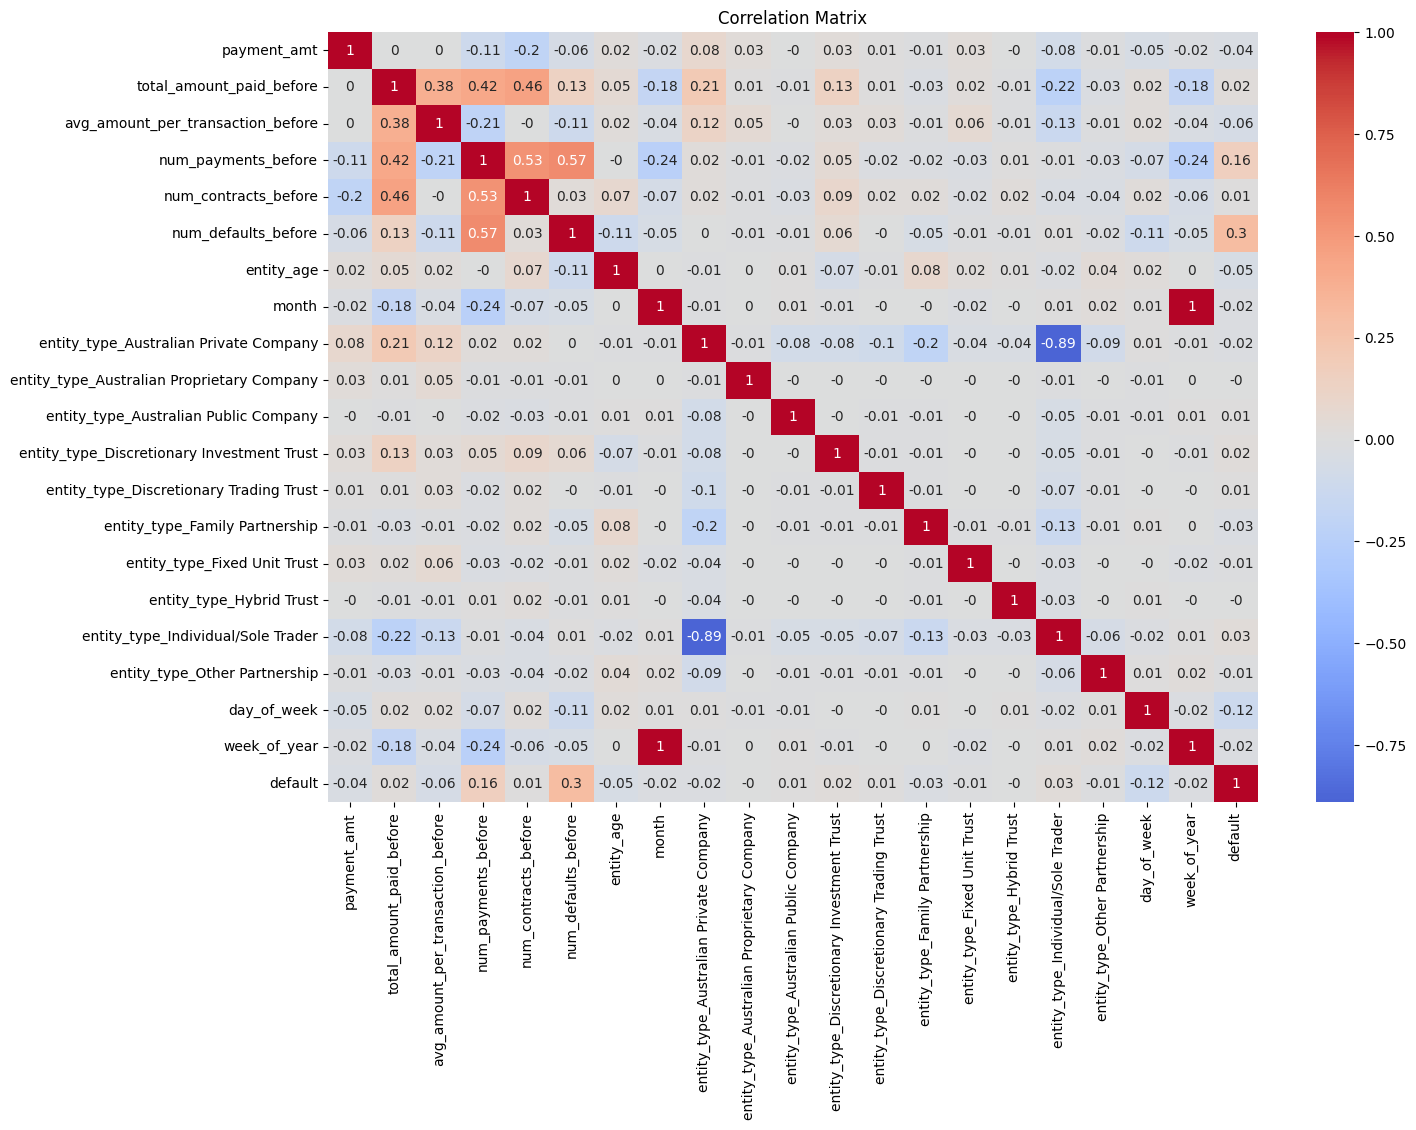

In [10]:
# Correlation matrix
plt.figure(figsize=(15, 10))
correlation_matrix = clients_payment_df.corr().round(2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()



In [11]:
# # normalise numeric variables
# numeric_cols = [
#     'total_amount_paid_before',
#     'avg_amount_per_transaction_before',
#     'num_payments_before',
#     'num_contracts_before',
#     'num_defaults_before',
#     'entity_age'
# ]
# for col in numeric_cols:
#     clients_payment_df[col] = (clients_payment_df[col] - clients_payment_df[col].mean()) / clients_payment_df[col].std()

#### Feature Importance in predicting Default payments from Random Forest Model

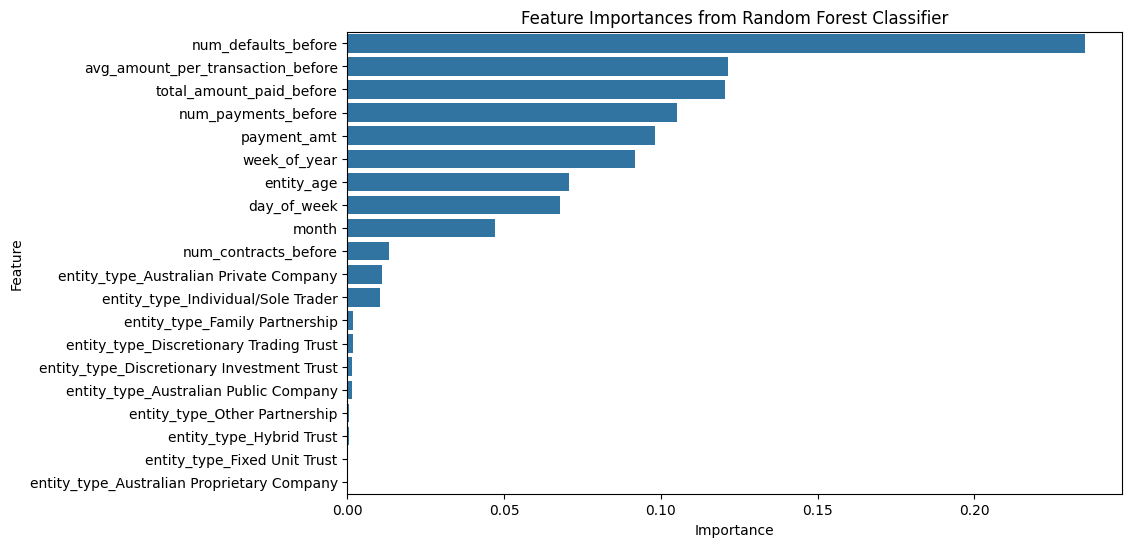

In [12]:
# Define features and target variable
y_fi = clients_payment_df['default']
X_fi = clients_payment_df.drop(columns=['default'])
# Split the data into training and testing sets
X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=0.2, random_state=42, stratify=y_fi)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_fi, y_train_fi)

feature_importances = pd.DataFrame({'Feature': X_fi.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Calculating Risk Scores & Risk Profiling Clients

In [13]:
# aggregated transaction data of each client

client_aggregated_payment_df = clients_payment_org.groupby('client_id').agg(
    total_amount_paid=('payment_amt', lambda x: x[clients_payment_org['payment_code'] != "DEFAULT"].sum()),
    avg_amount_per_transaction=('payment_amt', lambda x: x[clients_payment_org['payment_code'] != "DEFAULT"].mean()),
    num_payments=('payment_amt', lambda x: x[clients_payment_org['payment_code'] != "DEFAULT"].count()),
    num_contracts=('contract_id', 'nunique'),
    num_defaults=('payment_code', lambda x: (x == "DEFAULT").sum()),
    total_defaulted_amount=('payment_amt', lambda x: x[clients_payment_org['payment_code'] == "DEFAULT"].sum()),
).reset_index()

# Round the aggregated data where needed
client_aggregated_payment_df['total_amount_paid'] = client_aggregated_payment_df['total_amount_paid'].round(2)
client_aggregated_payment_df['avg_amount_per_transaction'] = client_aggregated_payment_df['avg_amount_per_transaction'].round(2)
client_aggregated_payment_df['total_defaulted_amount'] = client_aggregated_payment_df['total_defaulted_amount'].round(2)

# Show the aggregated data
client_aggregated_payment_df['entity_type'] = clients_payment_org['entity_type']
client_aggregated_payment_df['entity_age'] = clients_payment_org['entity_age']
print(client_aggregated_payment_df)

      client_id  total_amount_paid  avg_amount_per_transaction  num_payments  \
0             1            9016.68                      500.93            18   
1             2           25950.03                     3243.75             8   
2             3            4261.68                      213.08            20   
3             4            8016.56                      364.39            22   
4             5            5211.69                      868.62             6   
...         ...                ...                         ...           ...   
1276       1277           21731.73                     5432.93             4   
1277       1278            9999.98                     4999.99             2   
1278       1279          108658.32                    27164.58             4   
1279       1280           21731.73                     5432.93             4   
1280       1281           20000.06                    10000.03             2   

      num_contracts  num_defaults  tota

In [14]:
# time-based and age-based features

current_month = pd.Timestamp.now().month

client_aggregated_payment_df['in_risky_month'] = 0
client_aggregated_payment_df['in_risky_age'] = 0

# Define risky months based on entity type
def in_risky_month(entity_type, month):
    if entity_type == "Australian Private Company" and month == 7:
        return 1
    elif entity_type == "Australian Public Company" and month == 2:
        return 1
    elif entity_type == "Discretionary Investment Trust" and month in [3, 7]:
        return 1
    elif entity_type == "Discretionary Trading Trust" and month == 7:
        return 1
    elif entity_type == "Family Partnership" and month == 7:
        return 1
    elif entity_type == "Hybrid Trust" and month == 6:
        return 1
    elif entity_type == "Individual/Sole Trader" and month in [4, 5, 7]:
        return 1
    elif entity_type == "Other Partnership" and month in [8, 10, 11]:
        return 1
    return 0

# Define risky age ranges based on entity type
def in_risky_age(entity_type, age):
    if entity_type == "Australian Private Company" and age in [10, 12, 17]:
        return 1
    elif entity_type == "Australian Public Company" and age in [12, 13, 16]:
        return 1
    elif entity_type == "Discretionary Investment Trust" and age == 10:
        return 1
    elif entity_type == "Discretionary Trading Trust" and age == 12:
        return 1
    elif entity_type == "Family Partnership" and age in [14, 16]:
        return 1
    elif entity_type == "Hybrid Trust" and age == 18:
        return 1
    elif entity_type == "Individual/Sole Trader" and age in [10, 11, 16, 17, 18]:
        return 1
    elif entity_type == "Other Partnership" and age == 14:
        return 1
    return 0

# Define risky business types scores based on entity type
def risky_business_types(entity_type):
    risk_map = {
        'Discretionary Investment Trust': 4,  # Critical
        'Discretionary Trading Trust': 3,     # High
        'Australian Private Company': 4,      # Critical
        'Australian Public Company': 2,       # Medium
        'Hybrid Trust': 1,                    # Low
        'Individual/Sole Trader': 3,          # High
        'Other Partnership': 1,               # Low
        'Family Partnership': 2,              # Low
        'Australian Proprietary Company': 0,  # Very Low
        'Fixed Unit Trust': 0                 # Very Low
    }
    
    return risk_map.get(entity_type)

client_aggregated_payment_df['in_risky_month'] = client_aggregated_payment_df.apply(lambda row: in_risky_month(row['entity_type'], current_month), axis=1)
client_aggregated_payment_df['in_risky_age'] = client_aggregated_payment_df.apply(lambda row: in_risky_age(row['entity_type'], row['entity_age']), axis=1)
client_aggregated_payment_df['risky_business_types'] = client_aggregated_payment_df.apply(lambda row: risky_business_types(row['entity_type']), axis=1)
client_aggregated_payment_df

,client_id,total_amount_paid,avg_amount_per_transaction,num_payments,num_contracts,num_defaults,total_defaulted_amount,entity_type,entity_age,in_risky_month,in_risky_age,risky_business_types
0,1,9016.68,500.93,18,1,0,0.0,Other Partnership,19,0,0,1
1,2,25950.03,3243.75,8,1,0,0.0,Other Partnership,19,0,0,1
2,3,4261.68,213.08,20,2,0,0.0,Other Partnership,19,0,0,1
3,4,8016.56,364.39,22,1,0,0.0,Other Partnership,19,0,0,1
4,5,5211.69,868.62,6,1,0,0.0,Other Partnership,19,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1276,1277,21731.73,5432.93,4,1,0,0.0,Individual/Sole Trader,21,1,0,3
1277,1278,9999.98,4999.99,2,1,0,0.0,Individual/Sole Trader,21,1,0,3
1278,1279,108658.32,27164.58,4,1,0,0.0,Individual/Sole Trader,21,1,0,3
1279,1280,21731.73,5432.93,4,1,0,0.0,Individual/Sole Trader,21,1,0,3


In [15]:
def calculate_risk_score(row):
    risk_score = 0

    # Defaults-related risk (more defaults, higher risk)
    # The weights is based on the importance of the features in the RFC model but can be adjusted based on domain knowledge

    risk_score += row['num_defaults'] * 5  # Weight on the number of defaults

    # Use log transformation to scale total_amount_paid and avg_amount_per_transaction
    # Adding a small value to avoid log(0) in case of clients with no payments
    total_amount_paid_scaled = np.log(row['total_amount_paid'] + 1) 
    avg_transaction_scaled = np.log(row['avg_amount_per_transaction'] + 1)  
    total_defaulted_amount_scaled = np.log(row['total_defaulted_amount'] + 1)

    risk_score += (8 - total_amount_paid_scaled)  # Higher score for low-paying clients
    risk_score += (10 - avg_transaction_scaled)  # Higher score for lower avg transaction amounts
    risk_score += (20 - total_defaulted_amount_scaled)  # Penalize higher defaulted amounts

    # Risk from age and month
    if row['in_risky_month'] == 1:
        risk_score += 5 
    if row['in_risky_age'] == 1:
        risk_score += 5
    risk_score += 5*row['risky_business_types']

    return risk_score

# Apply the function to the dataframe
client_aggregated_payment_df['risk_score'] = client_aggregated_payment_df.apply(calculate_risk_score, axis=1)

client_aggregated_payment_df['log_risk_score'] = np.log(client_aggregated_payment_df['risk_score'] + 1)

risk_percentiles = client_aggregated_payment_df['log_risk_score'].quantile([0.35, 0.75, 0.9])

# Define thresholds for risk classification
client_aggregated_payment_df['risk_level'] = pd.cut(client_aggregated_payment_df['log_risk_score']
                                                    , bins= [0, risk_percentiles[0.35], risk_percentiles[0.75], risk_percentiles[0.9], client_aggregated_payment_df['risk_score'].max()]
                                                    , labels=['Low', 'Medium', 'High', 'Critical'])


# bins = [0, 20, 50, 100, 150]
# labels = ['Low', 'Medium', 'High', 'Critical']

# # Create the 'risk_level' column
# client_aggregated_payment_df['risk_level'] = pd.cut(client_aggregated_payment_df['log_risk_score'], bins=bins, labels=labels)

print(client_aggregated_payment_df[['client_id', 'risk_score', 'risk_level']])


      client_id  risk_score risk_level
0             1   27.674597        Low
1             2   24.751240        Low
2             3   29.275997        Low
3             4   28.109645        Low
4             5   27.673092        Low
...         ...         ...        ...
1276       1277   39.413007        Low
1277       1278   40.272170        Low
1278       1279   36.194321        Low
1279       1280   39.413007        Low
1280       1281   38.886016        Low

[1281 rows x 3 columns]


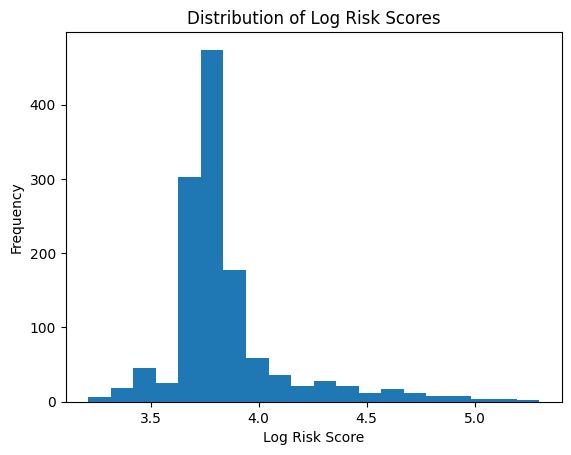

In [16]:
plt.hist(client_aggregated_payment_df['log_risk_score'], bins=20)
plt.title('Distribution of Log Risk Scores')
plt.xlabel('Log Risk Score')
plt.ylabel('Frequency')
plt.show()

Since the data is skewed, applying a log transformation (as shown in the code above) can help to compress the large values while retaining the distribution. The log transformation will make the bins more evenly spaced and will prevent outliers from dominating the bins.

In [17]:
# distribution of risk scores
client_aggregated_payment_df['risk_level'].value_counts()

risk_level
Medium      512
Low         449
High        192
Critical    128
Name: count, dtype: int64

The choice of quantiles for classifying risk levels—0.35, 0.75, and 0.9—is based on effectively distinguishing between low, medium, high, and critical risk clients.

- Medium (0.35 quantile) captures clients with moderate risk, while still separating them from the lower-risk group.

- High (0.75 quantile) ensures that high-risk clients are adequately identified.

- Critical (0.9 quantile) focuses on the top 10% of clients who pose the greatest threat, aligning with the goal of identifying clients who are most likely to default.

This approach balances preventive action (identifying high and critical risk clients) while being cost-effective since more critical/high-risk clients can be targeted for intervention, potentially reducing default-related losses without excessive resource expenditure.

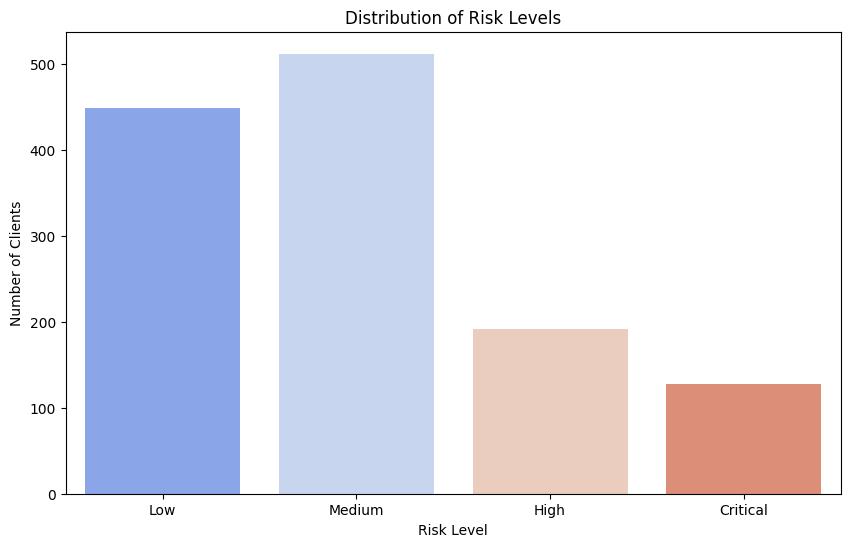

In [18]:
# Plot the risk levels
plt.figure(figsize=(10,6))
sns.countplot(data=client_aggregated_payment_df, x='risk_level', palette='coolwarm', hue='risk_level')
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Clients')
plt.show()

Once we classify the clients into different risk levels, we can apply targeted actions:

- High or Critical Risk:

    - Immediate intervention: Contact the client directly, assess their financial situation, and offer payment restructuring, financial counseling, or credit assistance.

    - Monitor closely: Set up alerts for their future transactions to monitor their behaviour in real-time.

    - Review credit terms: Lower the credit limit or demand collateral to mitigate future risk.

- Medium Risk:

    - Preventive intervention: Send payment reminders and notifications. Offer payment plans to avoid escalation.

    - Monitor activity: Keep an eye on payment behaviour, especially during risky months.

    - Increase client engagement: Offer special financial management tools or services to improve cash flow.

- Low Risk:

    - Maintain relationship: Continue to provide regular services but without special interventions.

    - Occasional monitoring: Keep basic monitoring in place, mainly for new contracts or during risky months.

## Modelling

In [19]:
train_df = clients_payment_df.copy()

y = train_df['default']
X = train_df.drop(columns=['default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Data Resampling

Text(0, 0.5, 'Count')

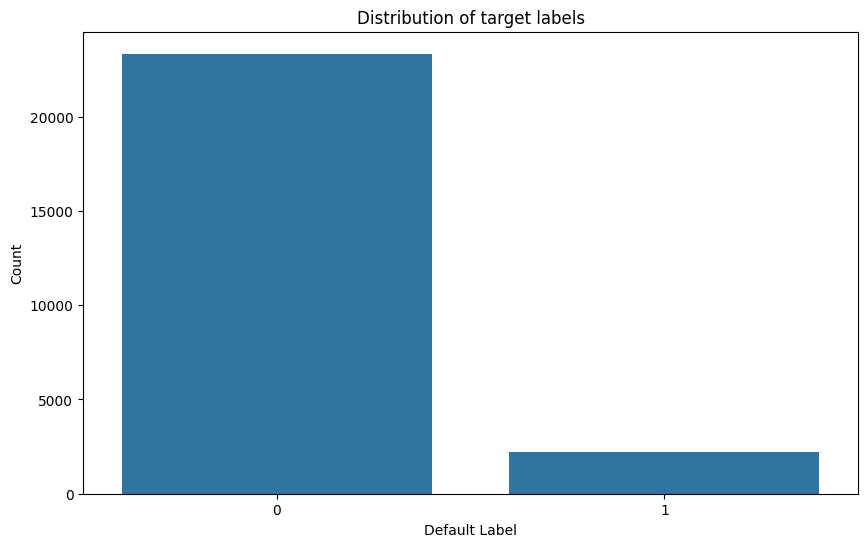

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='default', data=train_df)
plt.title('Distribution of target labels')
plt.xlabel('Default Label')
plt.ylabel('Count')

Here, we see that the default cases are under represented compared to non-default cases. Class imbalance can significantly impact the performance of predictive models, especially when we're trying to predict rare events like defaults. Models trained on imbalanced datasets tend to be biased towards the majority class (non-default), and they may struggle to correctly predict the minority class (defaults).

Thus, I would use the **Under Sampling** technique to undersample the majority class (non-default) by randomly reducing the number of non-default instances. 

In [21]:
# under sampling the majority class
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

y_rus.value_counts()

default
0    1775
1    1775
Name: count, dtype: int64

In [22]:
# # another method: over sampling the minority class
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
# X_ros, y_ros = ros.fit_resample(X_train, y_train)
# y_ros.value_counts()

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(sampling_strategy='minority', random_state=42)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)
# y_smote.value_counts()

### KNN

In [23]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1', n_jobs=-1)
knn_grid_search.fit(X_rus, y_rus)

knn_best = knn_grid_search.best_estimator_
knn_y_pred = knn_best.predict(X_test)

knn_best_model_recall = recall_score(y_test, knn_y_pred)
knn_best_model_precision = precision_score(y_test, knn_y_pred)
knn_best_model_f1 = f1_score(y_test, knn_y_pred)
knn_best_model_accuracy = accuracy_score(y_test, knn_y_pred)

print(f"Best KNN Model Recall Score: {knn_best_model_recall}")
print(f"Best KNN Model Precision Score: {knn_best_model_precision}")
print(f"Best KNN Model F1 Score: {knn_best_model_f1}")
print(f"Best KNN Model Accuracy Score: {knn_best_model_accuracy}")

Best KNN Model Recall Score: 0.7297297297297297
Best KNN Model Precision Score: 0.15458015267175573
Best KNN Model F1 Score: 0.2551181102362205
Best KNN Model Accuracy Score: 0.6298904538341158


### Random Forest Classifier

In [24]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)

random_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                                scoring="f1", cv=5, refit=True, n_jobs=-1)

random_search.fit(X_rus, y_rus)

rf_best = random_search.best_estimator_

rf_y_pred = rf_best.predict(X_test)

rf_recall = recall_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_accuracy = accuracy_score(y_test, rf_y_pred)

print(f"Random Forest Recall Score On Testing Set: {rf_recall}")
print(f"Random Forest Precision Score On Testing Set: {rf_precision}")
print(f"Random Forest F1 Score On Testing Set: {rf_f1}")
print(f"Random Forest Accuracy Score On Testing Set: {rf_accuracy}")

Random Forest Recall Score On Testing Set: 0.8806306306306306
Random Forest Precision Score On Testing Set: 0.28792341678939615
Random Forest F1 Score On Testing Set: 0.4339622641509434
Random Forest Accuracy Score On Testing Set: 0.8004694835680751


In [25]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15]
}

xg_classifier = XGBClassifier(random_state=42)


# random_search = RandomizedSearchCV(estimator=xg_classifier, param_distributions=param_grid, 
#                                     cv=5, scoring="f1", refit=True, random_state=42, n_jobs=-1)
random_search = GridSearchCV(estimator=xg_classifier, param_grid=param_grid, 
                                scoring="f1", cv=10, refit=True, n_jobs=-1)
random_search.fit(X_rus, y_rus)

xgb_best = random_search.best_estimator_

xgb_y_pred = xgb_best.predict(X_test)
xgb_y_pred_proba = xgb_best.predict_proba(X_test)[:, 1] # record the probabilities of default along with the default-prone flag

xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)

print(f"XGBoost Recall Score: {xgb_recall}")
print(f"XGBoost Precision Score: {xgb_precision}")
print(f"XGBoost F1 Score: {xgb_f1}")
print(f"XGBoost Accuracy Score: {xgb_accuracy}")

XGBoost Recall Score: 0.8671171171171171
XGBoost Precision Score: 0.31023368251410155
XGBoost F1 Score: 0.456973293768546
XGBoost Accuracy Score: 0.8210093896713615


### Stacking Model: Random Forest Classifier + K Nearest Neighbours + XGBoost

In [26]:
# stacking model
base_models = [
    ('rf', rf_best),
    # ('xgb', xgb_best),
    ('knn', knn_best),
]

meta_model = xgb_best

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(X_rus, y_rus)

stacking_y_pred = stacking_model.predict(X_test)
stacking_y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]
stacking_recall = recall_score(y_test, stacking_y_pred)
stacking_precision = precision_score(y_test, stacking_y_pred)
stacking_f1 = f1_score(y_test, stacking_y_pred)
stacking_accuracy = accuracy_score(y_test, stacking_y_pred)

print(f"Stacking Model Recall Score: {stacking_recall}")
print(f"Stacking Model Precision Score: {stacking_precision}")
print(f"Stacking Model F1 Score: {stacking_f1}")
print(f"Stacking Model Accuracy Score: {stacking_accuracy}")


Stacking Model Recall Score: 0.8671171171171171
Stacking Model Precision Score: 0.27898550724637683
Stacking Model F1 Score: 0.42214912280701755
Stacking Model Accuracy Score: 0.7938184663536776
